# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 144 rows (1 day), then skips 144 rows (1 day) before the next training window.

In [82]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = Path('.')
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 144    # 1 day of 10-minute samples
GAP = 0            # no skip between train and test blocks
from xgboost import XGBRegressor


In [83]:

# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = DATA_DIR / "micro_climate_rh_t_et0.xlsx"

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Parse timestamps (mixed formats, day-first)
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")
micro["timestamp"] = pd.to_datetime(micro["timestamp_dayfirst"], dayfirst=True, format="mixed")

# Convert numeric columns and drop columns that are completely empty
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()


(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [84]:
# Align all sources on timestamp
merged = micro.merge(weather, on="timestamp", how="inner").merge(radiation, on="timestamp", how="inner")
missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))
target_cols = ["internal_air_temp_c", "internal_rh_pct", "ET0", "internal_radiation"]
# Reindex to a continuous 10-minute grid; fill only exogenous columns to avoid time jumps
full_range = pd.date_range(merged["timestamp"].min(), merged["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()
exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()
# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")
# Time-of-day features
data["hour_frac"] = data["timestamp"].dt.hour + data["timestamp"].dt.minute/60
data["tod_sin"] = np.sin(2 * np.pi * data["hour_frac"] / 24)
data["tod_cos"] = np.cos(2 * np.pi * data["hour_frac"] / 24)
# RH anomaly and radiation ramp removed (rolling stats removed)
# Day/night indicator
data["is_night"] = data["timestamp"].dt.hour.isin([0,1,2,3,4,5,20,21,22,23]).astype(int)
feature_cols = [c for c in data.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
data.head()


diffuse_rad_wm2          0.893966
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 12,081
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,vpd_ext,abs_humidity_ext,dew_point_ext,diffuse_rad_wm2,global_rad_wm2,direct_rad_wm2,hour_frac,tod_sin,tod_cos,is_night
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,0.764606,13.122172,15.4,0.0,0.0,0.0,1.000000,0.258819,0.965926,1
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,0.759937,13.046358,15.3,0.0,0.0,0.0,1.166667,0.300706,0.953717,1
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,0.755292,12.970923,15.2,0.0,0.0,0.0,1.333333,0.342020,0.939693,1
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,0.800717,12.527413,14.7,0.0,0.0,0.0,1.500000,0.382683,0.923880,1
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,0.746077,12.821185,15.0,0.0,0.0,0.0,1.666667,0.422618,0.906308,1


In [85]:
# Define model and walk-forward routine with a gap after each test block
base_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.03,
    min_child_weight=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.1,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

def features_for_target(target):
    return feature_cols
def walk_forward(df, feature_cols, target_cols, model, train_window=TRAIN_WINDOW, test_window=TEST_WINDOW, gap=GAP):
    """Train on `train_window` rows, test on `test_window`, skip `gap`, repeat."""
    metrics = []
    preds = []
    cursor = 0
    run = 0
    while cursor + train_window + test_window <= len(df):
        train = df.iloc[cursor: cursor + train_window]
        test = df.iloc[cursor + train_window: cursor + train_window + test_window]

        preds_run = {}
        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }

        for t_col in target_cols:
            feat_cols_t = features_for_target(t_col)
            model_t = clone(model)
            model_t.fit(train[feat_cols_t], train[t_col])
            pred_t = model_t.predict(test[feat_cols_t])
            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)
        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )
        run += 1
        cursor += train_window + test_window  # step past train+test (no sliding overlap)
    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)





In [86]:

metrics_df, preds_df = walk_forward(data, feature_cols, target_cols, base_estimator)
display(metrics_df)

# Build a tidy summary: rows = variables (+ overall), cols = mae/r2
avg_mae = metrics_df[[c for c in metrics_df.columns if c.startswith("mae_")]].mean()
avg_r2 = metrics_df[[c for c in metrics_df.columns if c.startswith("r2_")]].mean()
summary_rows = []
for t in target_cols:
    summary_rows.append({"variable": t, "mae": avg_mae[f"mae_{t}"], "r2": avg_r2[f"r2_{t}"]})
summary_rows.append({"variable": "overall_mean", "mae": avg_mae.mean(), "r2": avg_r2.mean()})
summary = pd.DataFrame(summary_rows)[["variable", "mae", "r2"]]
display(summary)

# Optional: save for later analysis
# metrics_df.to_csv("walk_forward_metrics.csv", index=False)
# preds_df.to_csv("walk_forward_predictions.csv", index=False)


,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_air_temp_c,r2_internal_air_temp_c,mae_internal_rh_pct,r2_internal_rh_pct,mae_ET0,r2_ET0,mae_internal_radiation,r2_internal_radiation
0,0,2025-05-29 01:00:00,2025-06-16 00:50:00,2025-06-16 01:00:00,2025-06-17 01:00:00,1440,144,0.712642,0.938699,2.903165,0.914737,0.023523,0.974943,23.311968,0.972626
1,1,2025-06-17 01:10:00,2025-06-27 01:00:00,2025-06-27 01:10:00,2025-06-28 01:00:00,1440,144,0.541655,0.977379,3.332657,0.851463,0.037062,0.947403,33.440349,0.955627
2,2,2025-06-28 01:10:00,2025-07-16 01:10:00,2025-07-16 01:20:00,2025-07-17 01:20:00,1440,144,0.826491,0.944429,2.422671,0.879282,0.026814,0.969037,22.995766,0.979332
3,3,2025-07-17 01:30:00,2025-07-27 01:20:00,2025-07-27 01:30:00,2025-07-28 01:20:00,1440,144,0.280060,0.993133,2.794258,0.927289,0.023000,0.972975,16.782851,0.989430
4,4,2025-07-28 01:30:00,2025-08-15 01:30:00,2025-08-15 01:40:00,2025-08-16 01:30:00,1440,144,0.811598,0.940846,4.820152,0.855511,0.028525,0.963919,33.319258,0.965722
5,5,2025-08-16 01:40:00,2025-08-26 01:30:00,2025-08-26 01:40:00,2025-08-27 01:30:00,1440,144,0.586044,0.917928,3.798343,0.699639,0.032657,0.938599,30.681233,0.952272
6,6,2025-08-27 01:40:00,2025-09-14 01:30:00,2025-09-14 01:40:00,2025-09-15 01:30:00,1440,144,1.005872,0.930766,5.601364,0.707036,0.030509,0.935846,31.444343,0.939220


,variable,mae,r2
0,internal_air_temp_c,0.680623,0.949026
1,internal_rh_pct,3.667516,0.833565
2,ET0,0.028870,0.957532
3,internal_radiation,27.425110,0.964890
4,overall_mean,7.950530,0.926253


C:\Users\edene\AppData\Local\Temp\ipykernel_21248\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


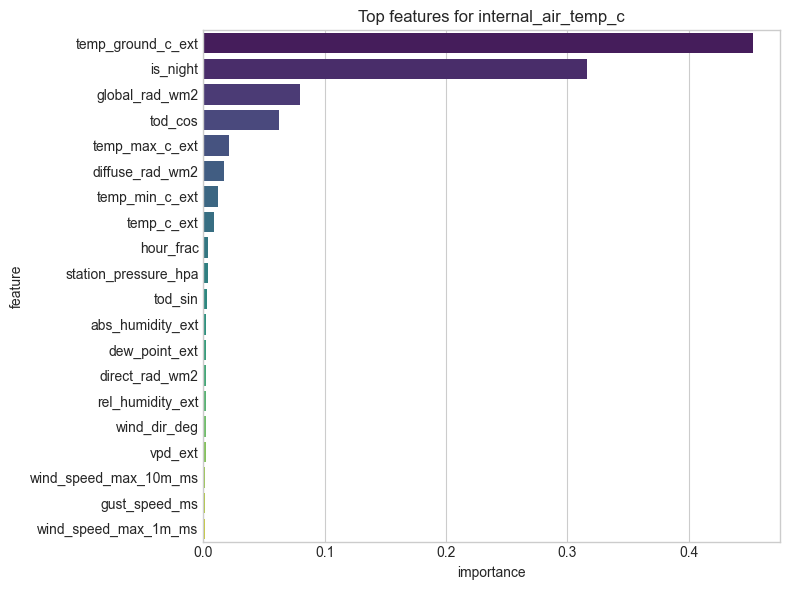

C:\Users\edene\AppData\Local\Temp\ipykernel_21248\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


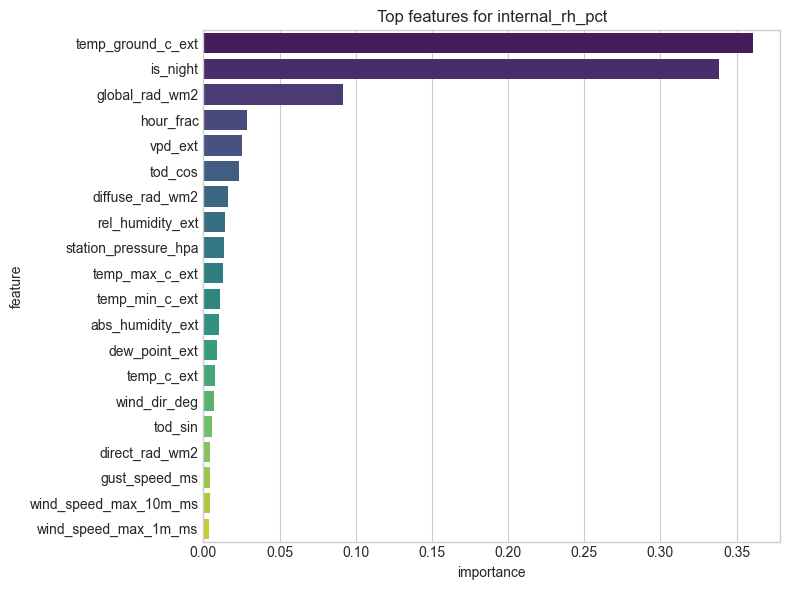

C:\Users\edene\AppData\Local\Temp\ipykernel_21248\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


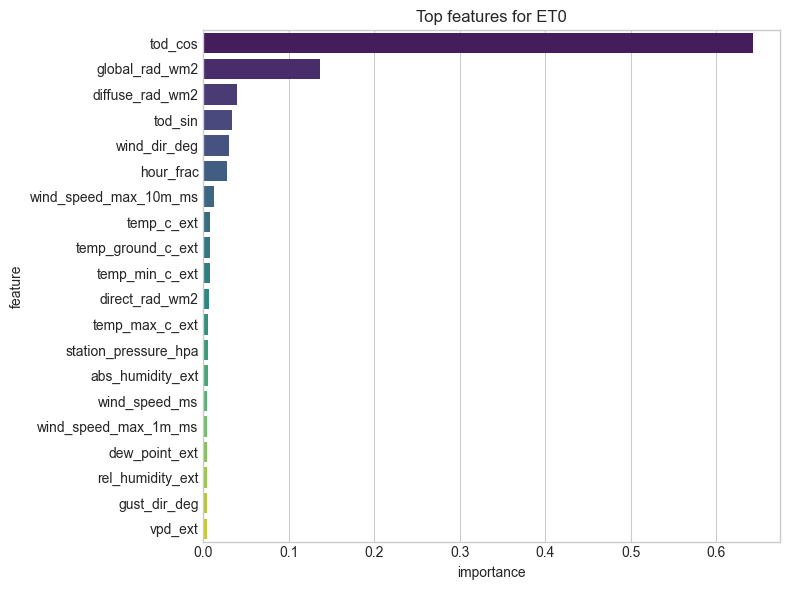

C:\Users\edene\AppData\Local\Temp\ipykernel_21248\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


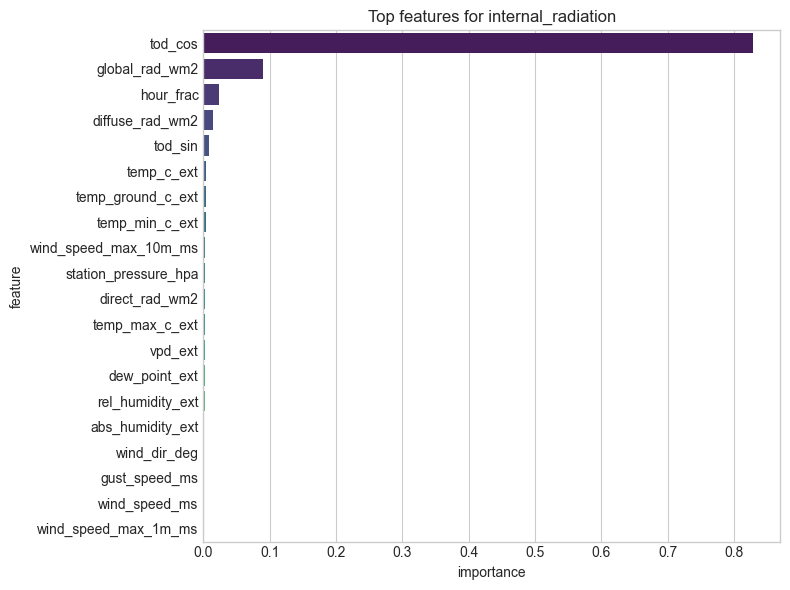

In [87]:

# Feature importance per target (trained once on full dataset)
imp_rows = []
for target in target_cols:
    feat_cols_t = features_for_target(target)
    model_t = clone(base_estimator)
    model_t.fit(data[feat_cols_t], data[target])
    fi = getattr(model_t, 'feature_importances_', None)
    if fi is None:
        print(f'No native feature_importances_ for target {target}; skipping')
        continue
    imp_rows.append(pd.DataFrame({'feature': feat_cols_t, 'importance': fi, 'target': target}))

if len(imp_rows) == 0:
    print('No feature importances available for this model type/version.')
else:
    importance_df = pd.concat(imp_rows, ignore_index=True)
    for target in target_cols:
        sub = importance_df[importance_df['target'] == target].sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(8, 6))
        sns.barplot(x='importance', y='feature', data=sub, palette='viridis')
        plt.title(f'Top features for {target}')
        plt.tight_layout()
        plt.show()
